In [1]:
import spateo as st
import matplotlib.pyplot as plt

st.config.n_threads = 32
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

2023-10-11 11:47:53.388911: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 11:47:53.432189: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 11:47:54.021883: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/mowp/mambaforge/envs/spateo/lib/python3.9/site-packages/libpysal/cg/alpha_shapes.py:39: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is cur

In [2]:
adata = st.io.read_bgi_agg(
    'SS200000135TL_D1_all_bin1.txt.gz', 'SS200000135IL-D1.ssDNA.tif',
)
adata

|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.


AnnData object with n_obs × n_vars = 2000 × 2000
    uns: '__type', 'pp', 'spatial'
    layers: 'stain', 'spliced', 'unspliced'

|-----> <select> stain layer in AnnData Object


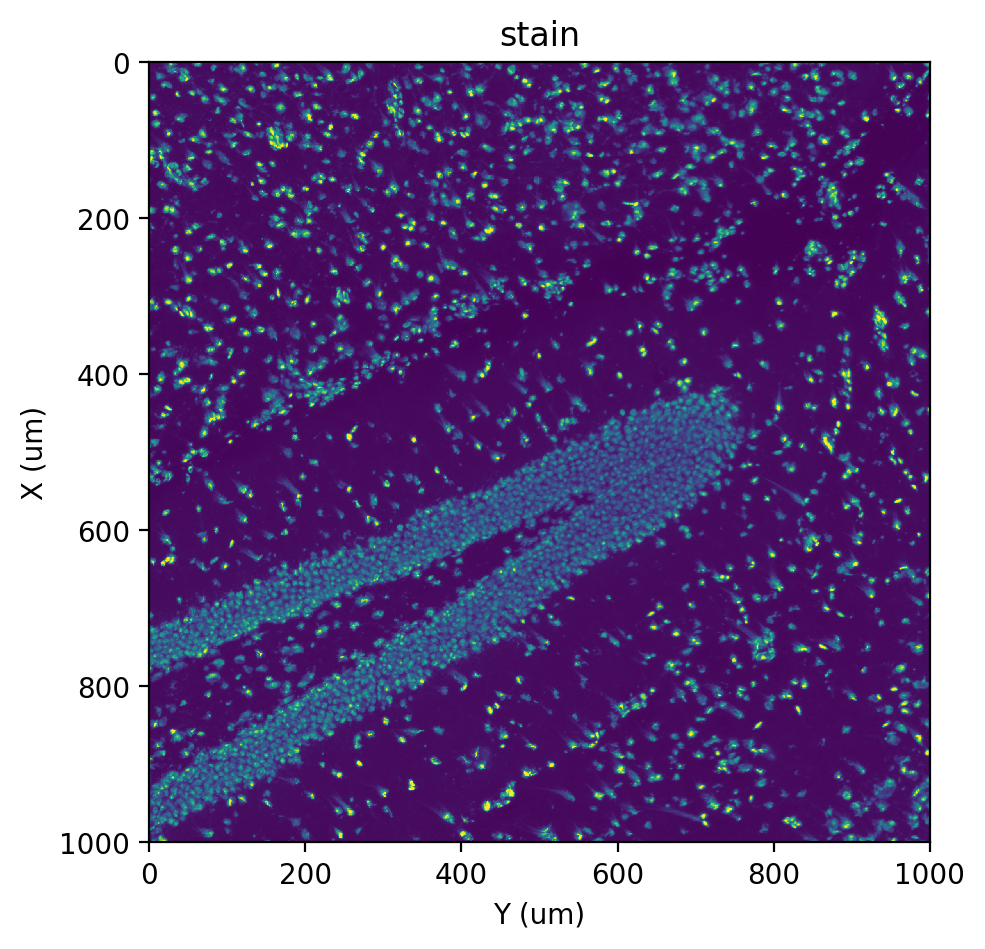

In [3]:
st.pl.imshow(adata, 'stain')

# Refine alignment

In [21]:
before = adata.layers['stain'].copy()
st.cs.refine_alignment(adata, mode='rigid', transform_layers=['stain'])

|-----> <select> stain layer in AnnData Object
|-----> <select> unspliced layer in AnnData Object
|-----> Refining alignment in rigid mode.


Loss -4.7442e-03: 100%|██████████| 100/100 [00:09<00:00, 10.33it/s]

|-----> Transforming layers ['stain']
|-----> <select> stain layer in AnnData Object


|-----> <insert> stain to layers in AnnData Object.


|-----> <select> unspliced layer in AnnData Object
|-----> <select> stain layer in AnnData Object
|-----> <select> unspliced layer in AnnData Object


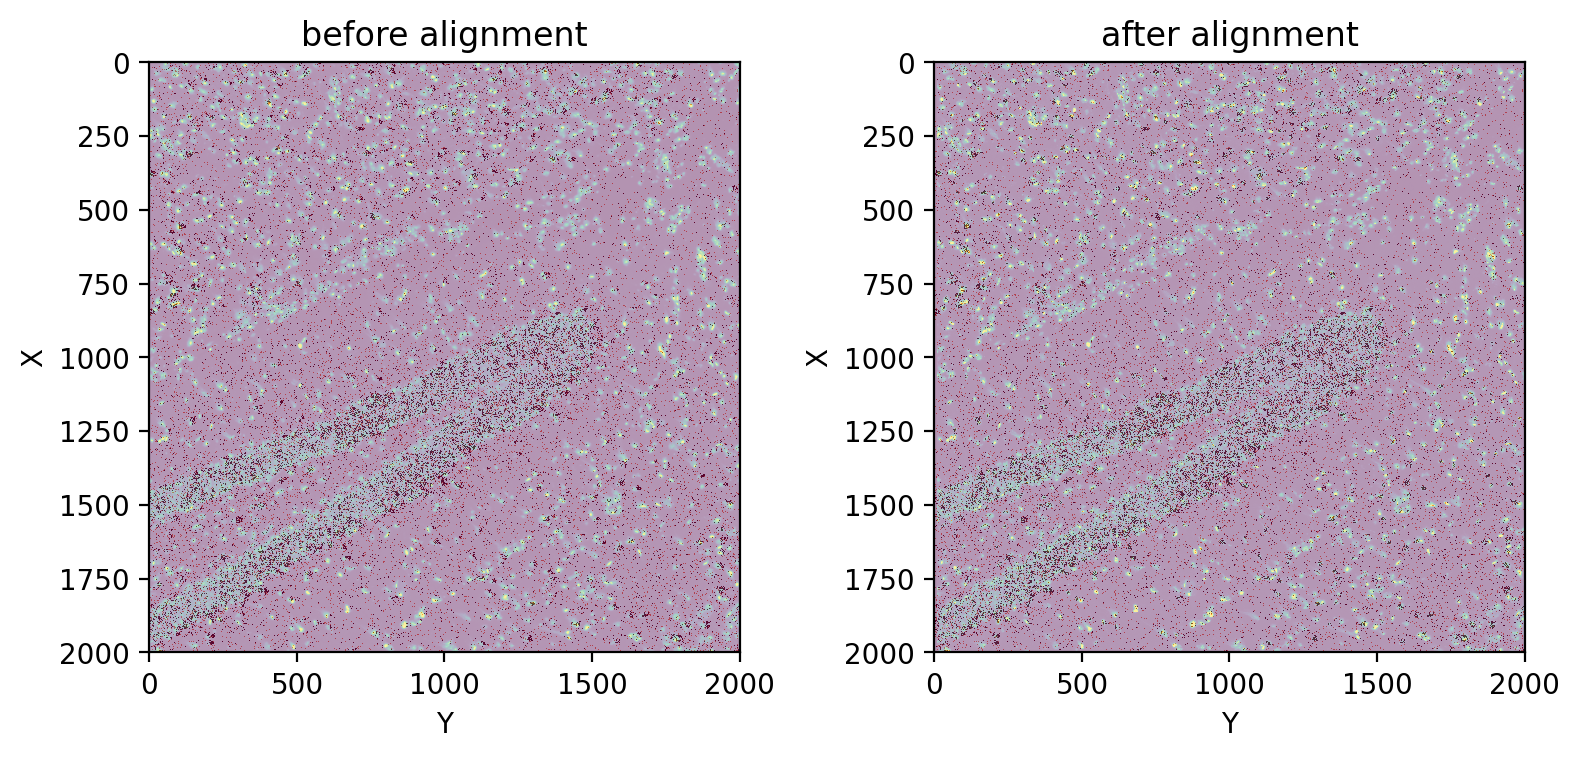

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), tight_layout=True)
axes[0].imshow(before)
st.pl.imshow(adata, 'unspliced', ax=axes[0], alpha=0.6, cmap='Reds', vmax=2, use_scale=False, save_show_or_return='return')
axes[0].set_title('before alignment')

st.pl.imshow(adata, 'stain', ax=axes[1], use_scale=False, save_show_or_return='return')
st.pl.imshow(adata, 'unspliced', ax=axes[1], alpha=0.6, cmap='Reds', vmax=2, use_scale=False, save_show_or_return='return')
axes[1].set_title('after alignment')

plt.show()

# Watershed-based approach

## Segmentation

|-----> <select> stain layer in AnnData Object
|-----> Constructing nuclei mask from staining image.
|-----> <insert> stain_mask to layers in AnnData Object.
|-----> <select> stain_mask layer in AnnData Object


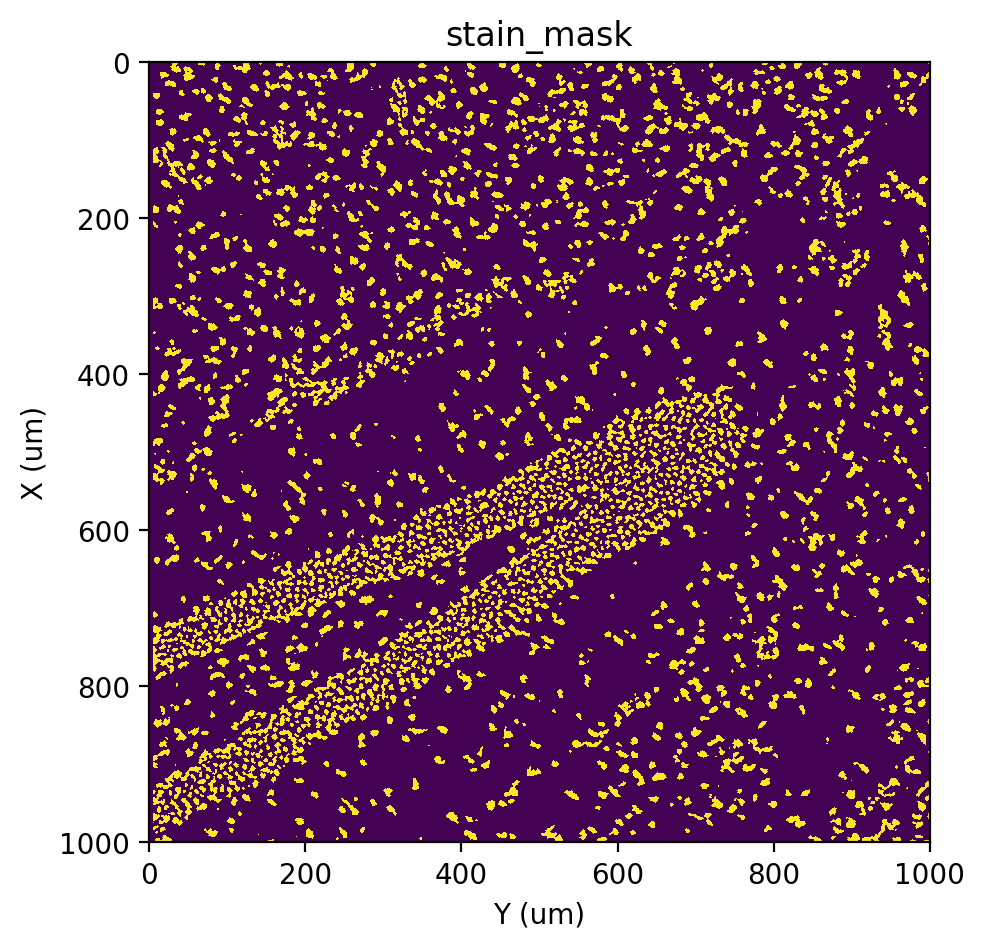

In [33]:
st.cs.mask_nuclei_from_stain(adata)
st.pl.imshow(adata, 'stain_mask')

## Labeling

|-----> <select> stain_mask layer in AnnData Object
|-----> Finding peaks with minimum distance 7.
|-----> <insert> stain_distances to layers in AnnData Object.
|-----> <insert> stain_markers to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> stain_mask layer in AnnData Object
|-----> <select> stain_markers layer in AnnData Object
|-----> Running Watershed.
|-----> <insert> watershed_labels to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> watershed_labels layer in AnnData Object


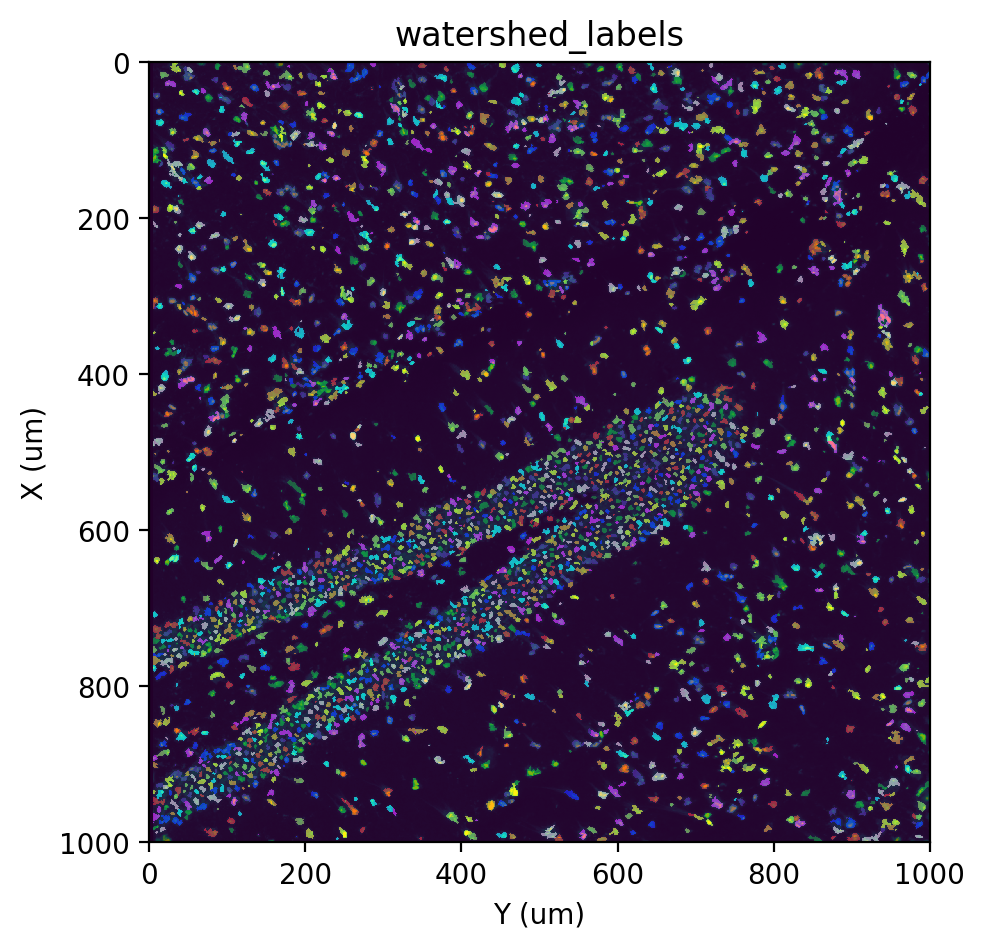

In [38]:
st.cs.find_peaks_from_mask(adata, 'stain', 7)
st.cs.watershed(adata, 'stain', 5, out_layer='watershed_labels')

fig, ax = st.pl.imshow(adata, 'stain', save_show_or_return='return')
st.pl.imshow(adata, 'watershed_labels', labels=True, alpha=0.5, ax=ax)

In [39]:
adata

AnnData object with n_obs × n_vars = 2000 × 2000
    uns: '__type', 'pp', 'spatial'
    layers: 'stain', 'spliced', 'unspliced', 'stain_mask', 'stain_distances', 'stain_markers', 'watershed_labels'

# Deep learning-based approach

|-----> <select> stain layer in AnnData Object
|-----> Equalizing image with CLAHE.
|-----> Running StarDist with model 2D_versatile_fluo.
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


/home/mowp/mambaforge/envs/spateo/lib/python3.9/site-packages/csbdeep/models/base_model.py:256: UserWarning:

skipping normalization step after prediction because number of input and output channels differ.



|-----> Fixing disconnected labels.
|-----> <insert> stardist_labels to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> stardist_labels layer in AnnData Object


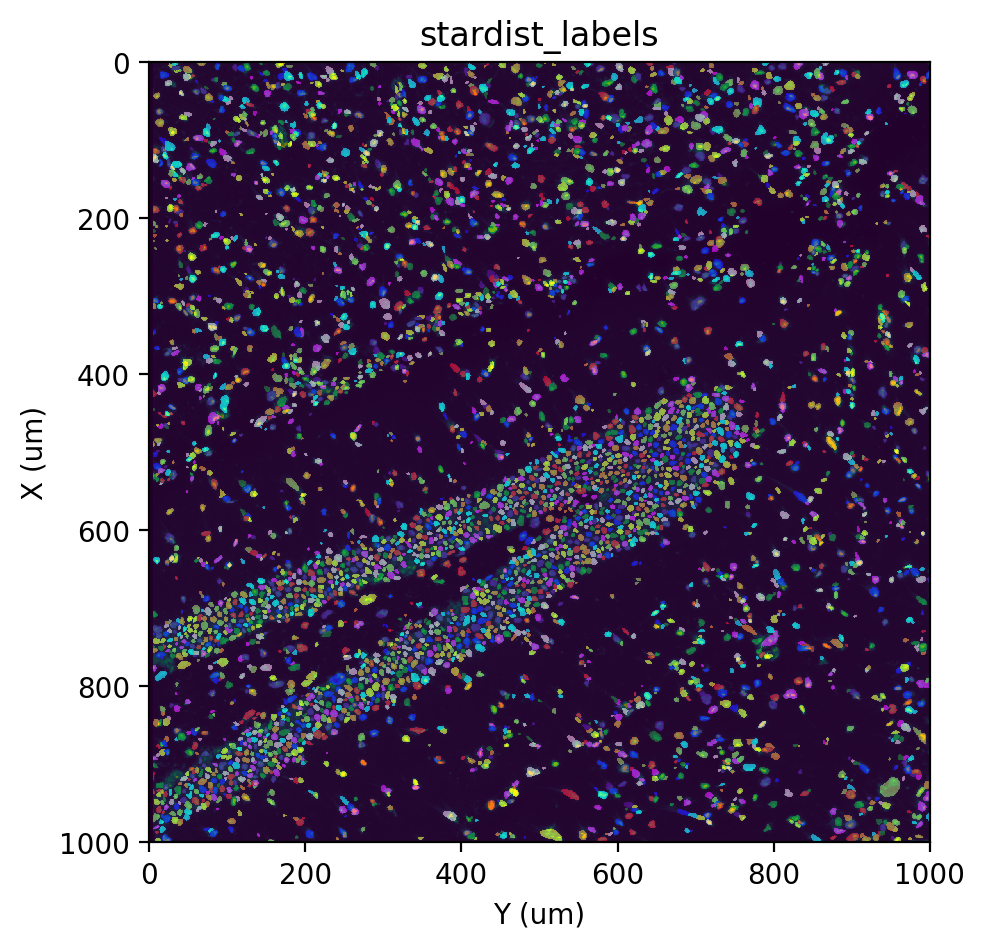

In [46]:
st.cs.stardist(adata, tilesize=-1, equalize=2.0, out_layer='stardist_labels')

fig, ax = st.pl.imshow(adata, 'stain', save_show_or_return='return')
st.pl.imshow(adata, 'stardist_labels', labels=True, alpha=0.5, ax=ax)

# [Optional] Augment labels

|-----> <select> watershed_labels layer in AnnData Object
|-----> <select> stardist_labels layer in AnnData Object
|-----> <insert> augmented_labels to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> augmented_labels layer in AnnData Object


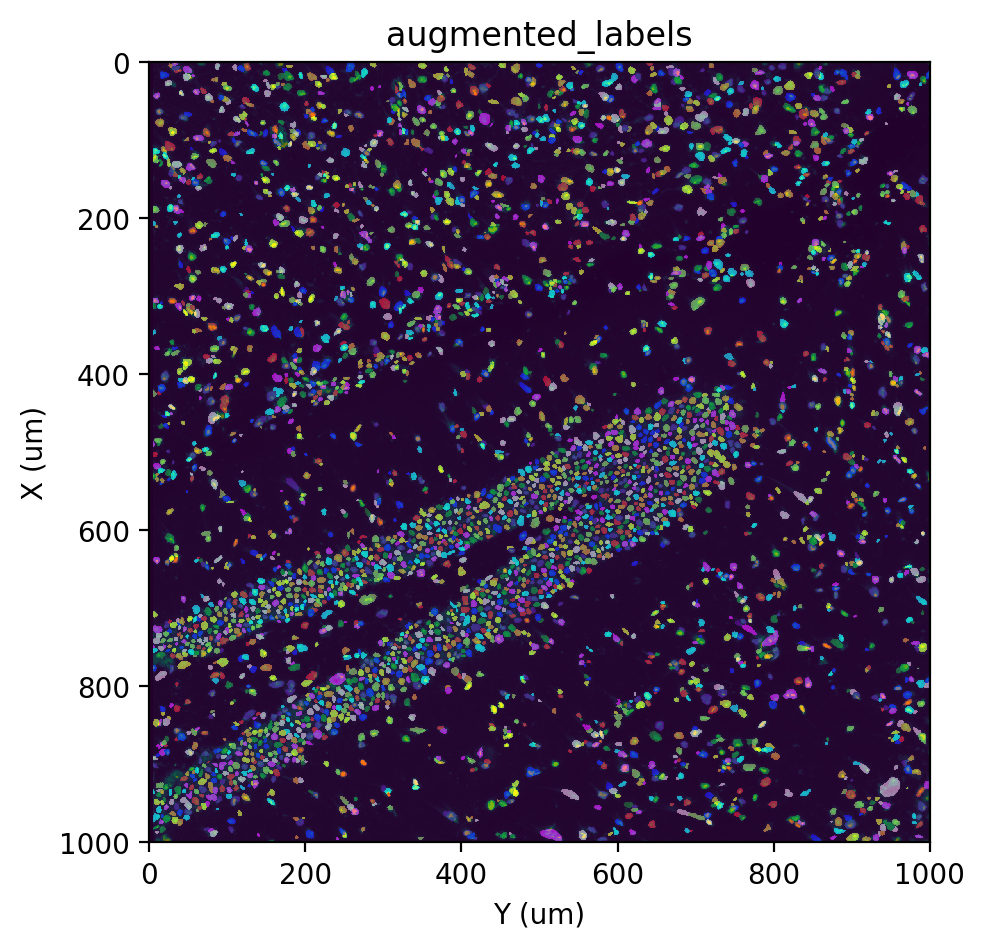

In [49]:
st.cs.augment_labels(adata, 'watershed_labels', 'stardist_labels', out_layer='augmented_labels')

fig, ax = st.pl.imshow(adata, 'stain', save_show_or_return='return')
st.pl.imshow(adata, 'augmented_labels', labels=True, alpha=0.5, ax=ax)

# [Optional] Expand labels to cytoplasm

In [50]:
st.cs.mask_cells_from_stain(adata, out_layer='stain_cell_mask')
st.cs.watershed(
    adata, 'stain',
    mask_layer='stain_cell_mask',
    markers_layer='augmented_labels',
    out_layer='cell_labels',
)

|-----> <select> stain layer in AnnData Object
|-----> Constructing cell mask from staining image.
|-----> <insert> stain_cell_mask to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> stain_cell_mask layer in AnnData Object
|-----> <select> augmented_labels layer in AnnData Object
|-----> Running Watershed.
|-----> <insert> cell_labels to layers in AnnData Object.


|-----> <select> stain layer in AnnData Object
|-----> <select> cell_labels layer in AnnData Object


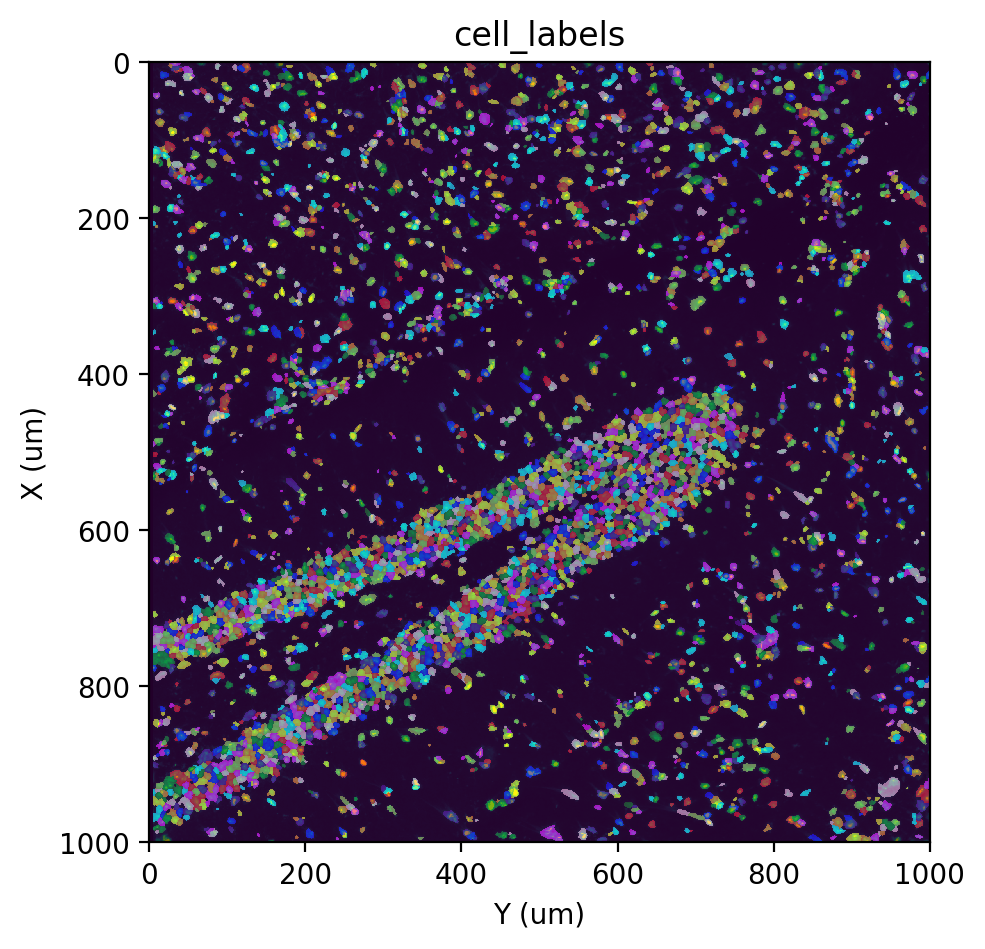

In [51]:
fig, ax = st.pl.imshow(adata, 'stain', save_show_or_return='return')
st.pl.imshow(adata, 'cell_labels', labels=True, alpha=0.5, ax=ax)

# Obtain a cell x gene matrix

|-----> <select> cell_labels layer in AnnData Object
|-----> Expanding labels.


Expanding:   0%|          | 0/2 [00:00<?, ?it/s]2023-10-11 13:05:35.321209: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 13:05:35.329622: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 13:05:35.410428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-11 13:05:35.507390: I te

|-----> <insert> cell_labels_expanded to layers in AnnData Object.
|-----> <select> stain layer in AnnData Object
|-----> <select> cell_labels_expanded layer in AnnData Object


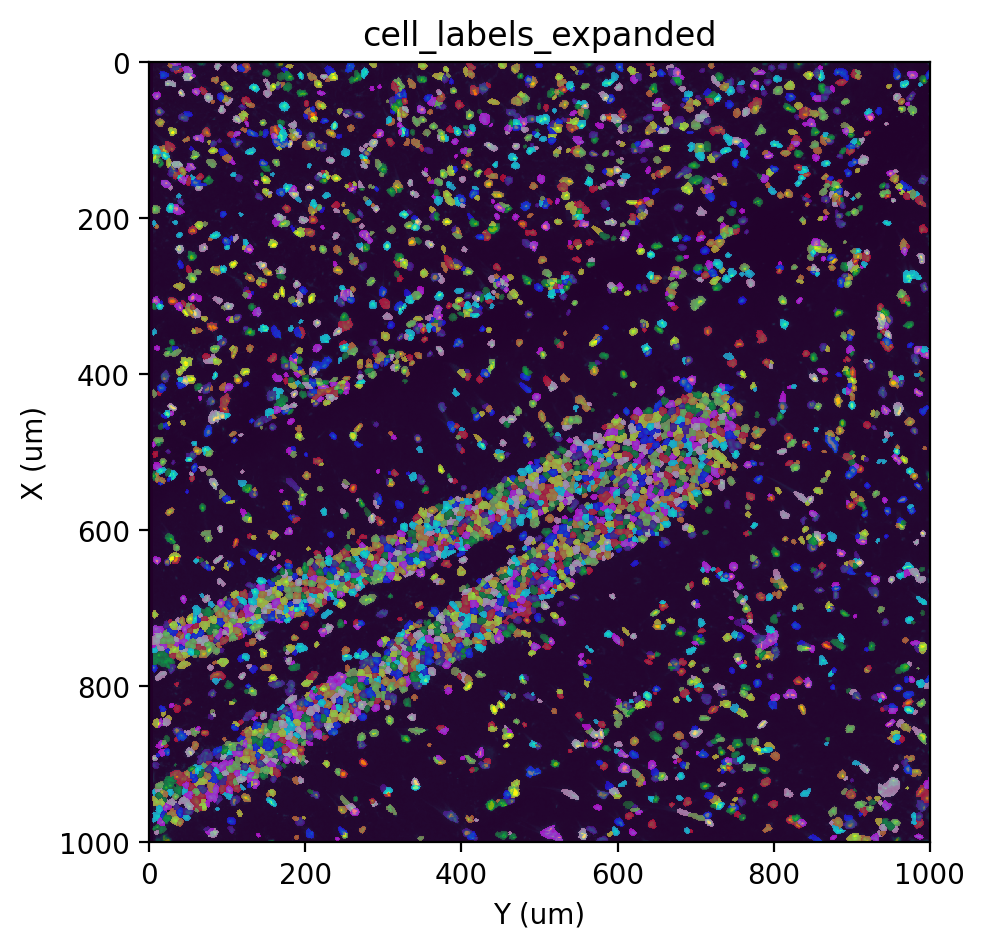

In [52]:
st.cs.expand_labels(
    adata, 'cell_labels', distance=2, out_layer='cell_labels_expanded'
)

fig, ax = st.pl.imshow(adata, 'stain', save_show_or_return='return')
st.pl.imshow(adata, 'cell_labels_expanded', labels=True, alpha=0.5, ax=ax)

In [53]:
cell_adata = st.io.read_bgi(
    'SS200000135TL_D1_all_bin1.txt.gz',
    segmentation_adata=adata,
    labels_layer='cell_labels_expanded',
)
cell_adata

|-----> <select> cell_labels_expanded layer in AnnData Object
|-----> Using labels provided with `segmentation_adata` and `labels_layer` arguments.
|-----> Constructing count matrices.
|-----> <insert> __type to uns in AnnData Object.
|-----> <insert> pp to uns in AnnData Object.
|-----> <insert> spatial to uns in AnnData Object.


/home/mowp/mambaforge/envs/spateo/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning:

Transforming to str index.



AnnData object with n_obs × n_vars = 4133 × 19815
    obs: 'area'
    uns: '__type', 'pp', 'spatial'
    obsm: 'spatial', 'contour', 'bbox'
    layers: 'spliced', 'unspliced'

In [55]:
cell_adata.obs

area
1     248.0
2     504.0
3     292.0
4     265.0
5     356.0
...     ...
4131  113.0
4132   59.0
4133   55.0
4134   91.0
4135   41.0

[4133 rows x 1 columns]

In [64]:
cell_adata.X

<4133x19815 sparse matrix of type '<class 'numpy.float32'>'
	with 1154561 stored elements in Compressed Sparse Row format>